### Importing libraries and MNIST dataset

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])

test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [3]:
m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

### Define Convolutional Autoencoder

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), #nn.Conv2d(wXhxc,stride=2,padding=1)
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1) #torch.flatten(input, start_dim=0, end_dim=- 1) → Tensor
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128), #torch.nn.Linear(in_features, out_features)
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Initialise the loss function

In [5]:
### Define the loss function = Mean square error
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 #learning rate

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [1]:
### Initialising the custom training loss function

### Train and evaluate model

#### orig

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

In [6]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    '''
    recon_loss =[]
    cluster_loss = []
    cluser_centers = [
        [0,0,0,0],
        x10
    ]
    '''
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        #calculate cluster loss
        
        cluster_loss.append()
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        recon_loss.append(loss.detach().cpu().numpy())
    
        

In [7]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [8]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.079855
	 partial train loss (single batch): 0.078821
	 partial train loss (single batch): 0.078942
	 partial train loss (single batch): 0.078293
	 partial train loss (single batch): 0.077498
	 partial train loss (single batch): 0.077026
	 partial train loss (single batch): 0.078606
	 partial train loss (single batch): 0.076367
	 partial train loss (single batch): 0.075256
	 partial train loss (single batch): 0.074852
	 partial train loss (single batch): 0.075789
	 partial train loss (single batch): 0.074365
	 partial train loss (single batch): 0.075043
	 partial train loss (single batch): 0.074745
	 partial train loss (single batch): 0.073949
	 partial train loss (single batch): 0.072917
	 partial train loss (single batch): 0.073181
	 partial train loss (single batch): 0.073037
	 partial train loss (single batch): 0.072845
	 partial train loss (single batch): 0.072078
	 partial train loss (single batch): 0.072617
	 partial train loss (single batch

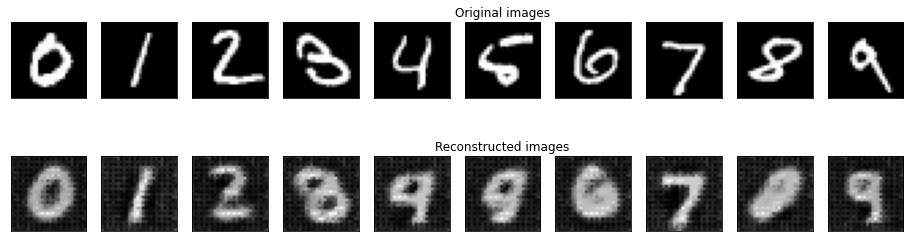

	 partial train loss (single batch): 0.050208
	 partial train loss (single batch): 0.048942
	 partial train loss (single batch): 0.050150
	 partial train loss (single batch): 0.049538
	 partial train loss (single batch): 0.048771
	 partial train loss (single batch): 0.048668
	 partial train loss (single batch): 0.050889
	 partial train loss (single batch): 0.048858
	 partial train loss (single batch): 0.047236
	 partial train loss (single batch): 0.047181
	 partial train loss (single batch): 0.049192
	 partial train loss (single batch): 0.047170
	 partial train loss (single batch): 0.049053
	 partial train loss (single batch): 0.049431
	 partial train loss (single batch): 0.048387
	 partial train loss (single batch): 0.047442
	 partial train loss (single batch): 0.047601
	 partial train loss (single batch): 0.048343
	 partial train loss (single batch): 0.048437
	 partial train loss (single batch): 0.048074
	 partial train loss (single batch): 0.048822
	 partial train loss (single batch

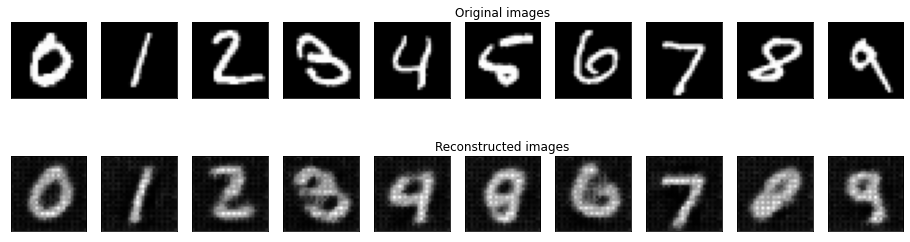

	 partial train loss (single batch): 0.040672
	 partial train loss (single batch): 0.039537
	 partial train loss (single batch): 0.040908
	 partial train loss (single batch): 0.039853
	 partial train loss (single batch): 0.039701
	 partial train loss (single batch): 0.039173
	 partial train loss (single batch): 0.041361
	 partial train loss (single batch): 0.039913
	 partial train loss (single batch): 0.037396
	 partial train loss (single batch): 0.038002
	 partial train loss (single batch): 0.039430
	 partial train loss (single batch): 0.037561
	 partial train loss (single batch): 0.039243
	 partial train loss (single batch): 0.040217
	 partial train loss (single batch): 0.039074
	 partial train loss (single batch): 0.038566
	 partial train loss (single batch): 0.037907
	 partial train loss (single batch): 0.038983
	 partial train loss (single batch): 0.039270
	 partial train loss (single batch): 0.039299
	 partial train loss (single batch): 0.039772
	 partial train loss (single batch

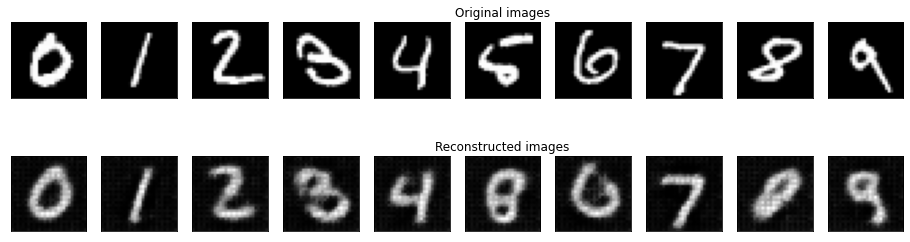

	 partial train loss (single batch): 0.035865
	 partial train loss (single batch): 0.034553
	 partial train loss (single batch): 0.035787
	 partial train loss (single batch): 0.034432
	 partial train loss (single batch): 0.034571
	 partial train loss (single batch): 0.034234
	 partial train loss (single batch): 0.036109
	 partial train loss (single batch): 0.035240
	 partial train loss (single batch): 0.032165
	 partial train loss (single batch): 0.032885
	 partial train loss (single batch): 0.034201
	 partial train loss (single batch): 0.032551
	 partial train loss (single batch): 0.034010
	 partial train loss (single batch): 0.035388
	 partial train loss (single batch): 0.034520
	 partial train loss (single batch): 0.033818
	 partial train loss (single batch): 0.032938
	 partial train loss (single batch): 0.034017
	 partial train loss (single batch): 0.034461
	 partial train loss (single batch): 0.035117
	 partial train loss (single batch): 0.035351
	 partial train loss (single batch

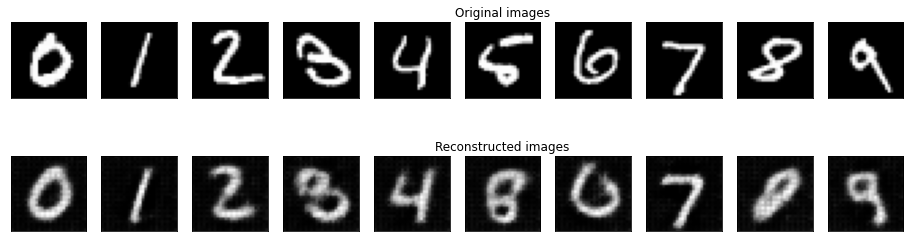

	 partial train loss (single batch): 0.033674
	 partial train loss (single batch): 0.032305
	 partial train loss (single batch): 0.033702
	 partial train loss (single batch): 0.032077
	 partial train loss (single batch): 0.032158
	 partial train loss (single batch): 0.031945
	 partial train loss (single batch): 0.033856
	 partial train loss (single batch): 0.033241
	 partial train loss (single batch): 0.029995
	 partial train loss (single batch): 0.030896
	 partial train loss (single batch): 0.031862
	 partial train loss (single batch): 0.030555
	 partial train loss (single batch): 0.031958
	 partial train loss (single batch): 0.033099
	 partial train loss (single batch): 0.032380
	 partial train loss (single batch): 0.031739
	 partial train loss (single batch): 0.030772
	 partial train loss (single batch): 0.031833
	 partial train loss (single batch): 0.032453
	 partial train loss (single batch): 0.033185
	 partial train loss (single batch): 0.033420
	 partial train loss (single batch

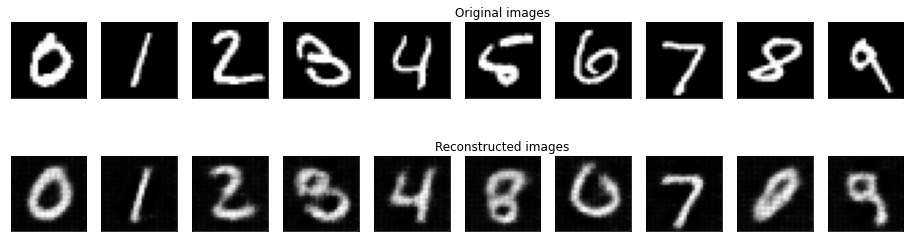

	 partial train loss (single batch): 0.032509
	 partial train loss (single batch): 0.031121
	 partial train loss (single batch): 0.032465
	 partial train loss (single batch): 0.030776
	 partial train loss (single batch): 0.030953
	 partial train loss (single batch): 0.030565
	 partial train loss (single batch): 0.032563
	 partial train loss (single batch): 0.031962
	 partial train loss (single batch): 0.028607
	 partial train loss (single batch): 0.029742
	 partial train loss (single batch): 0.030433
	 partial train loss (single batch): 0.029341
	 partial train loss (single batch): 0.030799
	 partial train loss (single batch): 0.031766
	 partial train loss (single batch): 0.031110
	 partial train loss (single batch): 0.030441
	 partial train loss (single batch): 0.029570
	 partial train loss (single batch): 0.030549
	 partial train loss (single batch): 0.031293
	 partial train loss (single batch): 0.031825
	 partial train loss (single batch): 0.032183
	 partial train loss (single batch

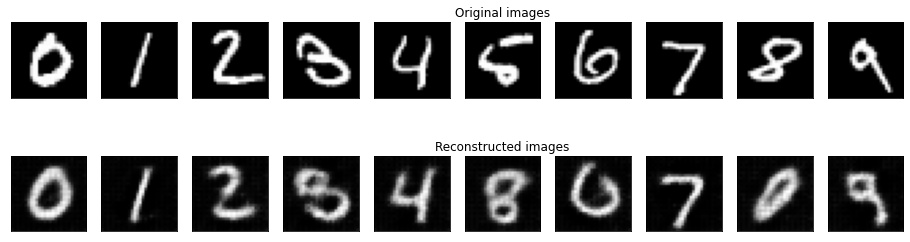

	 partial train loss (single batch): 0.031529
	 partial train loss (single batch): 0.030127
	 partial train loss (single batch): 0.031730
	 partial train loss (single batch): 0.030026
	 partial train loss (single batch): 0.030018
	 partial train loss (single batch): 0.029760
	 partial train loss (single batch): 0.031644
	 partial train loss (single batch): 0.031369
	 partial train loss (single batch): 0.027815
	 partial train loss (single batch): 0.028900
	 partial train loss (single batch): 0.029534
	 partial train loss (single batch): 0.028607
	 partial train loss (single batch): 0.030060
	 partial train loss (single batch): 0.030863
	 partial train loss (single batch): 0.030119
	 partial train loss (single batch): 0.029630
	 partial train loss (single batch): 0.028767
	 partial train loss (single batch): 0.029737
	 partial train loss (single batch): 0.030383
	 partial train loss (single batch): 0.031011
	 partial train loss (single batch): 0.031214
	 partial train loss (single batch

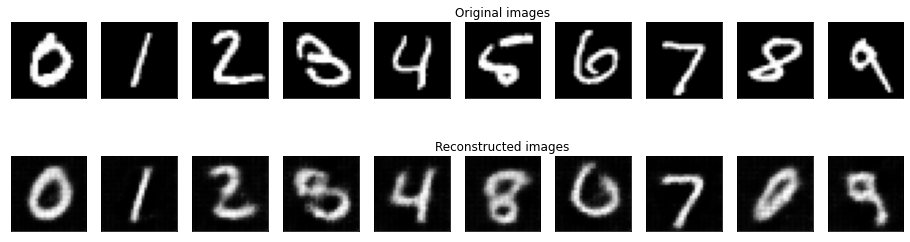

	 partial train loss (single batch): 0.030917
	 partial train loss (single batch): 0.029657
	 partial train loss (single batch): 0.031325
	 partial train loss (single batch): 0.029535
	 partial train loss (single batch): 0.029473
	 partial train loss (single batch): 0.029342
	 partial train loss (single batch): 0.031250
	 partial train loss (single batch): 0.030872
	 partial train loss (single batch): 0.027252
	 partial train loss (single batch): 0.028274
	 partial train loss (single batch): 0.029065
	 partial train loss (single batch): 0.028038
	 partial train loss (single batch): 0.029388
	 partial train loss (single batch): 0.030180
	 partial train loss (single batch): 0.029453
	 partial train loss (single batch): 0.029089
	 partial train loss (single batch): 0.028119
	 partial train loss (single batch): 0.029114
	 partial train loss (single batch): 0.029829
	 partial train loss (single batch): 0.030400
	 partial train loss (single batch): 0.030554
	 partial train loss (single batch

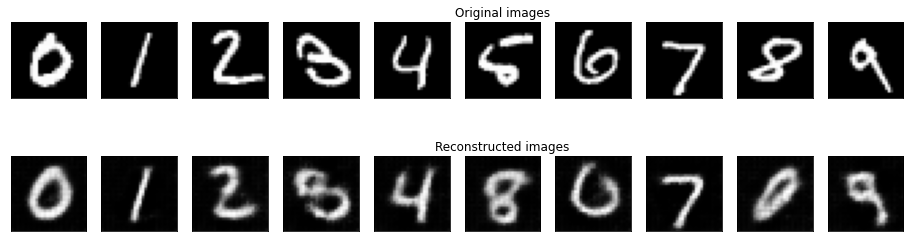

	 partial train loss (single batch): 0.030362
	 partial train loss (single batch): 0.029235
	 partial train loss (single batch): 0.030823
	 partial train loss (single batch): 0.029163
	 partial train loss (single batch): 0.029035
	 partial train loss (single batch): 0.028805
	 partial train loss (single batch): 0.030762
	 partial train loss (single batch): 0.030429
	 partial train loss (single batch): 0.026772
	 partial train loss (single batch): 0.027865
	 partial train loss (single batch): 0.028524
	 partial train loss (single batch): 0.027683
	 partial train loss (single batch): 0.028928
	 partial train loss (single batch): 0.029718
	 partial train loss (single batch): 0.029011
	 partial train loss (single batch): 0.028648
	 partial train loss (single batch): 0.027560
	 partial train loss (single batch): 0.028633
	 partial train loss (single batch): 0.029370
	 partial train loss (single batch): 0.029948
	 partial train loss (single batch): 0.030113
	 partial train loss (single batch

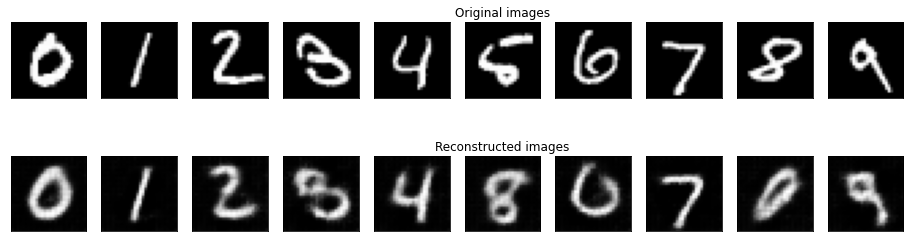

	 partial train loss (single batch): 0.029997
	 partial train loss (single batch): 0.028855
	 partial train loss (single batch): 0.030464
	 partial train loss (single batch): 0.028710
	 partial train loss (single batch): 0.028660
	 partial train loss (single batch): 0.028389
	 partial train loss (single batch): 0.030317
	 partial train loss (single batch): 0.030096
	 partial train loss (single batch): 0.026424
	 partial train loss (single batch): 0.027483
	 partial train loss (single batch): 0.028154
	 partial train loss (single batch): 0.027372
	 partial train loss (single batch): 0.028445
	 partial train loss (single batch): 0.029213
	 partial train loss (single batch): 0.028619
	 partial train loss (single batch): 0.028224
	 partial train loss (single batch): 0.027192
	 partial train loss (single batch): 0.028263
	 partial train loss (single batch): 0.028960
	 partial train loss (single batch): 0.029585
	 partial train loss (single batch): 0.029714
	 partial train loss (single batch

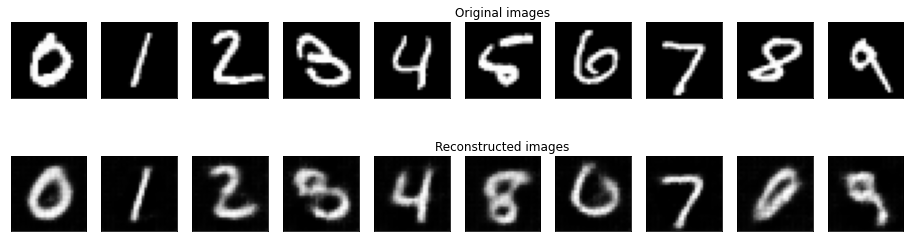

	 partial train loss (single batch): 0.029705
	 partial train loss (single batch): 0.028556
	 partial train loss (single batch): 0.030195
	 partial train loss (single batch): 0.028397
	 partial train loss (single batch): 0.028426
	 partial train loss (single batch): 0.028024
	 partial train loss (single batch): 0.029935
	 partial train loss (single batch): 0.029857
	 partial train loss (single batch): 0.026211
	 partial train loss (single batch): 0.027154
	 partial train loss (single batch): 0.027848
	 partial train loss (single batch): 0.027146
	 partial train loss (single batch): 0.028148
	 partial train loss (single batch): 0.028935
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.027931
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.028050
	 partial train loss (single batch): 0.028706
	 partial train loss (single batch): 0.029257
	 partial train loss (single batch): 0.029466
	 partial train loss (single batch

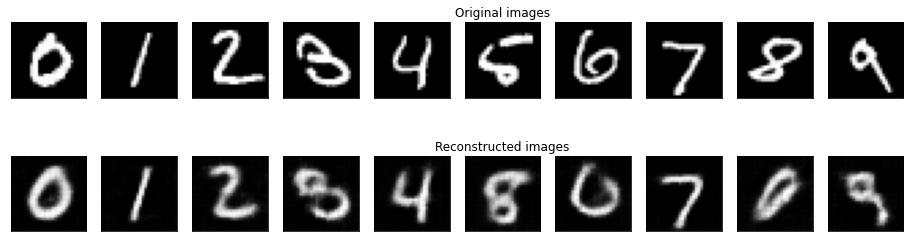

	 partial train loss (single batch): 0.029373
	 partial train loss (single batch): 0.028359
	 partial train loss (single batch): 0.029939
	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.028163
	 partial train loss (single batch): 0.027729
	 partial train loss (single batch): 0.029633
	 partial train loss (single batch): 0.029530
	 partial train loss (single batch): 0.025946
	 partial train loss (single batch): 0.026967
	 partial train loss (single batch): 0.027597
	 partial train loss (single batch): 0.026908
	 partial train loss (single batch): 0.027865
	 partial train loss (single batch): 0.028619
	 partial train loss (single batch): 0.028089
	 partial train loss (single batch): 0.027622
	 partial train loss (single batch): 0.026734
	 partial train loss (single batch): 0.027710
	 partial train loss (single batch): 0.028399
	 partial train loss (single batch): 0.029010
	 partial train loss (single batch): 0.029237
	 partial train loss (single batch

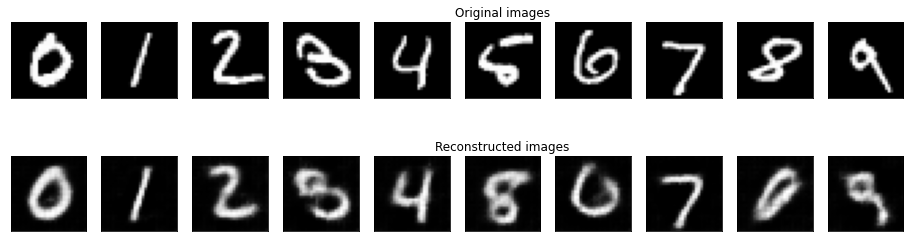

	 partial train loss (single batch): 0.029144
	 partial train loss (single batch): 0.028157
	 partial train loss (single batch): 0.029710
	 partial train loss (single batch): 0.027994
	 partial train loss (single batch): 0.028036
	 partial train loss (single batch): 0.027522
	 partial train loss (single batch): 0.029393
	 partial train loss (single batch): 0.029301
	 partial train loss (single batch): 0.025788
	 partial train loss (single batch): 0.026738
	 partial train loss (single batch): 0.027417
	 partial train loss (single batch): 0.026790
	 partial train loss (single batch): 0.027644
	 partial train loss (single batch): 0.028330
	 partial train loss (single batch): 0.027900
	 partial train loss (single batch): 0.027456
	 partial train loss (single batch): 0.026595
	 partial train loss (single batch): 0.027482
	 partial train loss (single batch): 0.028140
	 partial train loss (single batch): 0.028798
	 partial train loss (single batch): 0.028999
	 partial train loss (single batch

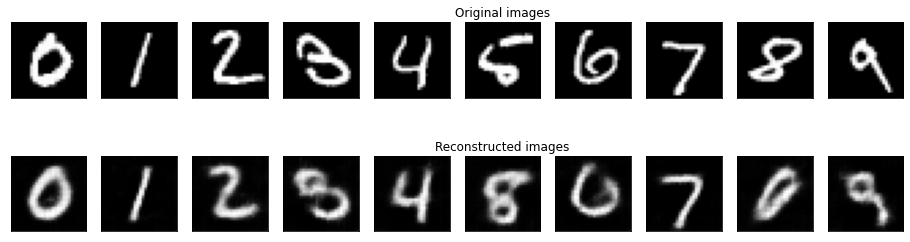

	 partial train loss (single batch): 0.029001
	 partial train loss (single batch): 0.027941
	 partial train loss (single batch): 0.029485
	 partial train loss (single batch): 0.027821
	 partial train loss (single batch): 0.027890
	 partial train loss (single batch): 0.027275
	 partial train loss (single batch): 0.029070
	 partial train loss (single batch): 0.029123
	 partial train loss (single batch): 0.025597
	 partial train loss (single batch): 0.026528
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.026506
	 partial train loss (single batch): 0.027454
	 partial train loss (single batch): 0.028181
	 partial train loss (single batch): 0.027740
	 partial train loss (single batch): 0.027326
	 partial train loss (single batch): 0.026490
	 partial train loss (single batch): 0.027342
	 partial train loss (single batch): 0.027800
	 partial train loss (single batch): 0.028572
	 partial train loss (single batch): 0.028868
	 partial train loss (single batch

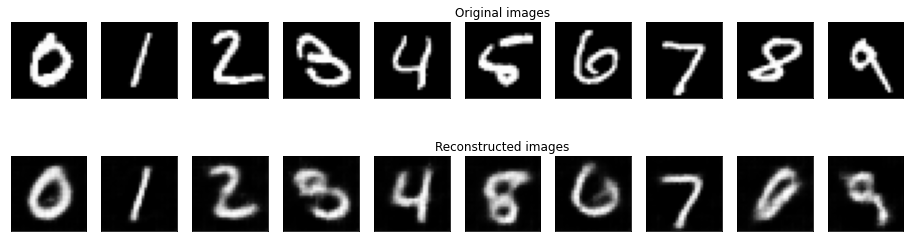

	 partial train loss (single batch): 0.028830
	 partial train loss (single batch): 0.027798
	 partial train loss (single batch): 0.029290
	 partial train loss (single batch): 0.027662
	 partial train loss (single batch): 0.027801
	 partial train loss (single batch): 0.027068
	 partial train loss (single batch): 0.028868
	 partial train loss (single batch): 0.028890
	 partial train loss (single batch): 0.025471
	 partial train loss (single batch): 0.026355
	 partial train loss (single batch): 0.027179
	 partial train loss (single batch): 0.026368
	 partial train loss (single batch): 0.027293
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.027663
	 partial train loss (single batch): 0.027165
	 partial train loss (single batch): 0.026393
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.028369
	 partial train loss (single batch): 0.028683
	 partial train loss (single batch

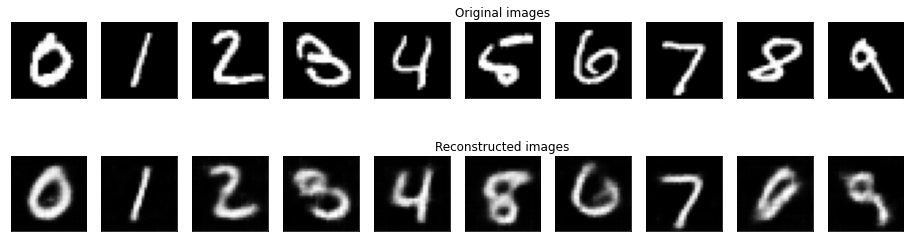

	 partial train loss (single batch): 0.028797
	 partial train loss (single batch): 0.027532
	 partial train loss (single batch): 0.029124
	 partial train loss (single batch): 0.027516
	 partial train loss (single batch): 0.027652
	 partial train loss (single batch): 0.026917
	 partial train loss (single batch): 0.028775
	 partial train loss (single batch): 0.028793
	 partial train loss (single batch): 0.025357
	 partial train loss (single batch): 0.026198
	 partial train loss (single batch): 0.027080
	 partial train loss (single batch): 0.026225
	 partial train loss (single batch): 0.027191
	 partial train loss (single batch): 0.027906
	 partial train loss (single batch): 0.027528
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.026899
	 partial train loss (single batch): 0.027481
	 partial train loss (single batch): 0.028207
	 partial train loss (single batch): 0.028499
	 partial train loss (single batch

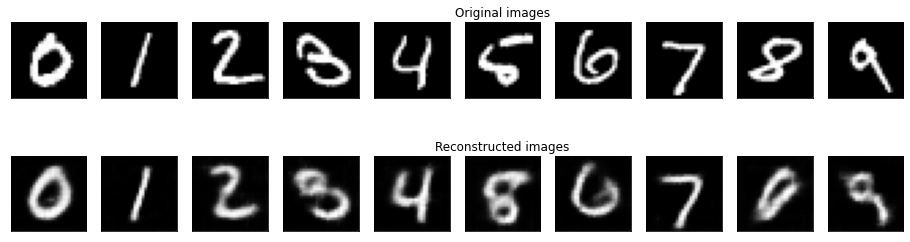

	 partial train loss (single batch): 0.028679
	 partial train loss (single batch): 0.027346
	 partial train loss (single batch): 0.029110
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.027507
	 partial train loss (single batch): 0.026779
	 partial train loss (single batch): 0.028697
	 partial train loss (single batch): 0.028634
	 partial train loss (single batch): 0.025343
	 partial train loss (single batch): 0.026116
	 partial train loss (single batch): 0.026959
	 partial train loss (single batch): 0.026170
	 partial train loss (single batch): 0.027124
	 partial train loss (single batch): 0.027786
	 partial train loss (single batch): 0.027409
	 partial train loss (single batch): 0.027076
	 partial train loss (single batch): 0.026212
	 partial train loss (single batch): 0.026826
	 partial train loss (single batch): 0.027305
	 partial train loss (single batch): 0.028048
	 partial train loss (single batch): 0.028282
	 partial train loss (single batch

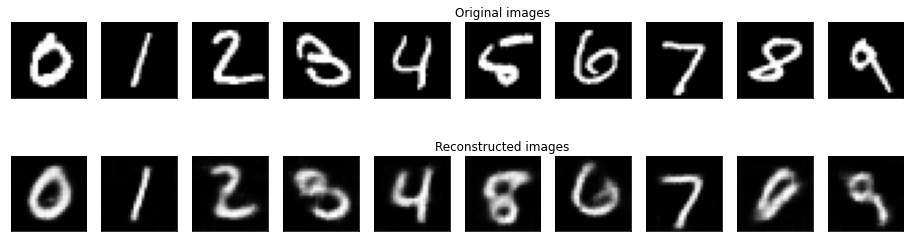

	 partial train loss (single batch): 0.028566
	 partial train loss (single batch): 0.027100
	 partial train loss (single batch): 0.028982
	 partial train loss (single batch): 0.027344
	 partial train loss (single batch): 0.027385
	 partial train loss (single batch): 0.026576
	 partial train loss (single batch): 0.028640
	 partial train loss (single batch): 0.028487
	 partial train loss (single batch): 0.025080
	 partial train loss (single batch): 0.026030
	 partial train loss (single batch): 0.026824
	 partial train loss (single batch): 0.025927
	 partial train loss (single batch): 0.027024
	 partial train loss (single batch): 0.027674
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.026197
	 partial train loss (single batch): 0.026611
	 partial train loss (single batch): 0.027213
	 partial train loss (single batch): 0.027897
	 partial train loss (single batch): 0.028100
	 partial train loss (single batch

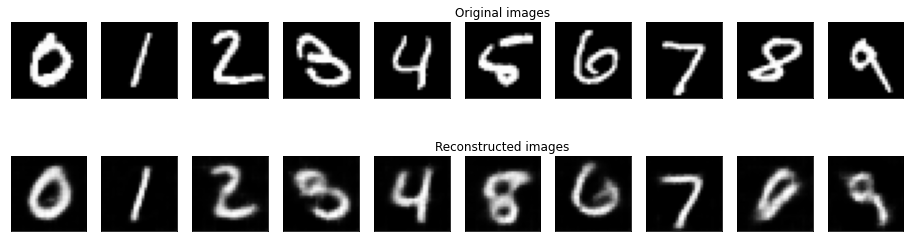

	 partial train loss (single batch): 0.028473
	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.028803
	 partial train loss (single batch): 0.027220
	 partial train loss (single batch): 0.027238
	 partial train loss (single batch): 0.026343
	 partial train loss (single batch): 0.028376
	 partial train loss (single batch): 0.028248
	 partial train loss (single batch): 0.024942
	 partial train loss (single batch): 0.025816
	 partial train loss (single batch): 0.026634
	 partial train loss (single batch): 0.025753
	 partial train loss (single batch): 0.026744
	 partial train loss (single batch): 0.027525
	 partial train loss (single batch): 0.027135
	 partial train loss (single batch): 0.026712
	 partial train loss (single batch): 0.025923
	 partial train loss (single batch): 0.026434
	 partial train loss (single batch): 0.027028
	 partial train loss (single batch): 0.027759
	 partial train loss (single batch): 0.028012
	 partial train loss (single batch

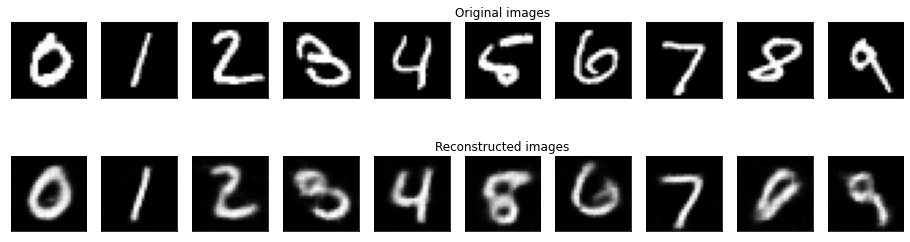

	 partial train loss (single batch): 0.028466
	 partial train loss (single batch): 0.026926
	 partial train loss (single batch): 0.028702
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.027192
	 partial train loss (single batch): 0.026253
	 partial train loss (single batch): 0.028297
	 partial train loss (single batch): 0.028148
	 partial train loss (single batch): 0.024892
	 partial train loss (single batch): 0.025754
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.025702
	 partial train loss (single batch): 0.026594
	 partial train loss (single batch): 0.027333
	 partial train loss (single batch): 0.027089
	 partial train loss (single batch): 0.026593
	 partial train loss (single batch): 0.025795
	 partial train loss (single batch): 0.026326
	 partial train loss (single batch): 0.026944
	 partial train loss (single batch): 0.027686
	 partial train loss (single batch): 0.027792
	 partial train loss (single batch

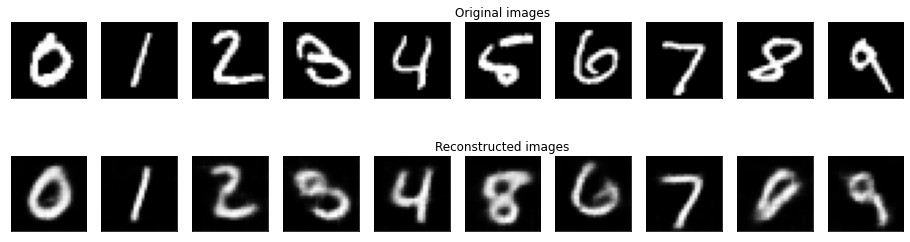

	 partial train loss (single batch): 0.028262
	 partial train loss (single batch): 0.026839
	 partial train loss (single batch): 0.028528
	 partial train loss (single batch): 0.027012
	 partial train loss (single batch): 0.027119
	 partial train loss (single batch): 0.026174
	 partial train loss (single batch): 0.028151
	 partial train loss (single batch): 0.028088
	 partial train loss (single batch): 0.024753
	 partial train loss (single batch): 0.025610
	 partial train loss (single batch): 0.026431
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.026577
	 partial train loss (single batch): 0.027285
	 partial train loss (single batch): 0.027015
	 partial train loss (single batch): 0.026492
	 partial train loss (single batch): 0.025774
	 partial train loss (single batch): 0.026271
	 partial train loss (single batch): 0.026933
	 partial train loss (single batch): 0.027666
	 partial train loss (single batch): 0.027688
	 partial train loss (single batch

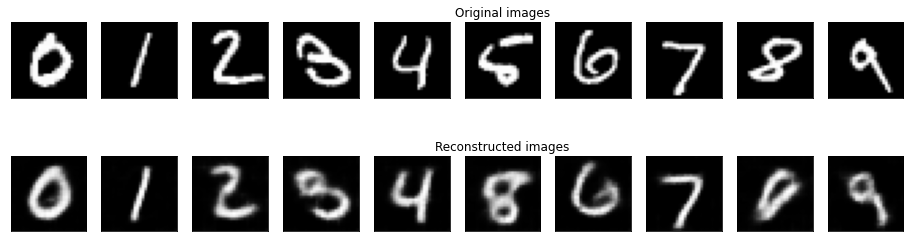

	 partial train loss (single batch): 0.028184
	 partial train loss (single batch): 0.026818
	 partial train loss (single batch): 0.028469
	 partial train loss (single batch): 0.026892
	 partial train loss (single batch): 0.027061
	 partial train loss (single batch): 0.026030
	 partial train loss (single batch): 0.028077
	 partial train loss (single batch): 0.027947
	 partial train loss (single batch): 0.024707
	 partial train loss (single batch): 0.025582
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.025555
	 partial train loss (single batch): 0.026481
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch): 0.026947
	 partial train loss (single batch): 0.026431
	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.026217
	 partial train loss (single batch): 0.026780
	 partial train loss (single batch): 0.027571
	 partial train loss (single batch): 0.027572
	 partial train loss (single batch

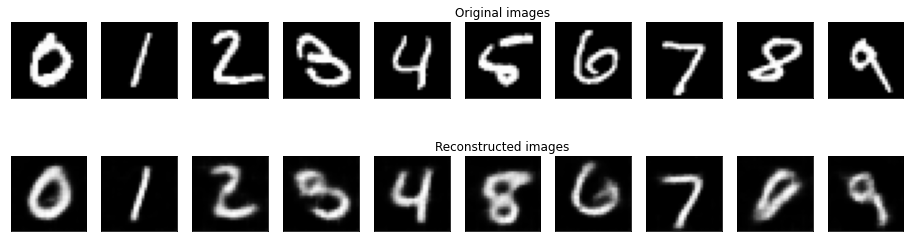

	 partial train loss (single batch): 0.028055
	 partial train loss (single batch): 0.026580
	 partial train loss (single batch): 0.028295
	 partial train loss (single batch): 0.026736
	 partial train loss (single batch): 0.026895
	 partial train loss (single batch): 0.025964
	 partial train loss (single batch): 0.027942
	 partial train loss (single batch): 0.027742
	 partial train loss (single batch): 0.024630
	 partial train loss (single batch): 0.025486
	 partial train loss (single batch): 0.026142
	 partial train loss (single batch): 0.025531
	 partial train loss (single batch): 0.026423
	 partial train loss (single batch): 0.026922
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.026402
	 partial train loss (single batch): 0.025639
	 partial train loss (single batch): 0.026095
	 partial train loss (single batch): 0.026694
	 partial train loss (single batch): 0.027451
	 partial train loss (single batch): 0.027485
	 partial train loss (single batch

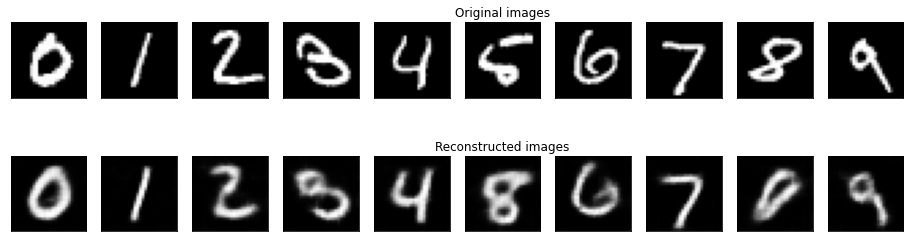

	 partial train loss (single batch): 0.027912
	 partial train loss (single batch): 0.026517
	 partial train loss (single batch): 0.028231
	 partial train loss (single batch): 0.026646
	 partial train loss (single batch): 0.026838
	 partial train loss (single batch): 0.025862
	 partial train loss (single batch): 0.027883
	 partial train loss (single batch): 0.027655
	 partial train loss (single batch): 0.024547
	 partial train loss (single batch): 0.025378
	 partial train loss (single batch): 0.026079
	 partial train loss (single batch): 0.025468
	 partial train loss (single batch): 0.026324
	 partial train loss (single batch): 0.026785
	 partial train loss (single batch): 0.026677
	 partial train loss (single batch): 0.026266
	 partial train loss (single batch): 0.025552
	 partial train loss (single batch): 0.025915
	 partial train loss (single batch): 0.026552
	 partial train loss (single batch): 0.027405
	 partial train loss (single batch): 0.027433
	 partial train loss (single batch

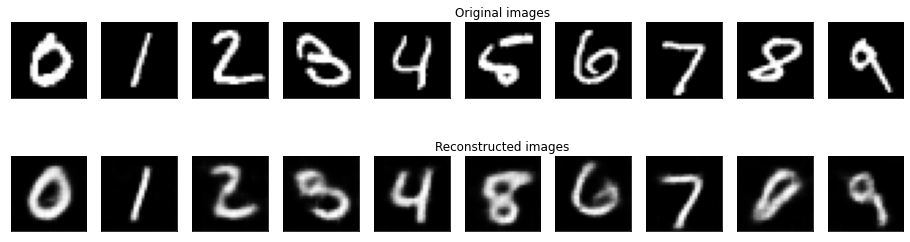

	 partial train loss (single batch): 0.027922
	 partial train loss (single batch): 0.026443
	 partial train loss (single batch): 0.028176
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch): 0.025768
	 partial train loss (single batch): 0.027738
	 partial train loss (single batch): 0.027627
	 partial train loss (single batch): 0.024535
	 partial train loss (single batch): 0.025367
	 partial train loss (single batch): 0.026011
	 partial train loss (single batch): 0.025364
	 partial train loss (single batch): 0.026294
	 partial train loss (single batch): 0.026759
	 partial train loss (single batch): 0.026591
	 partial train loss (single batch): 0.026247
	 partial train loss (single batch): 0.025574
	 partial train loss (single batch): 0.025961
	 partial train loss (single batch): 0.026465
	 partial train loss (single batch): 0.027354
	 partial train loss (single batch): 0.027386
	 partial train loss (single batch

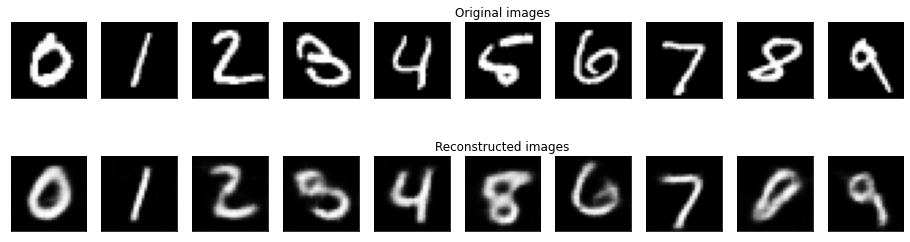

	 partial train loss (single batch): 0.027721
	 partial train loss (single batch): 0.026308
	 partial train loss (single batch): 0.028106
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.026664
	 partial train loss (single batch): 0.025632
	 partial train loss (single batch): 0.027616
	 partial train loss (single batch): 0.027478
	 partial train loss (single batch): 0.024382
	 partial train loss (single batch): 0.025290
	 partial train loss (single batch): 0.025870
	 partial train loss (single batch): 0.025311
	 partial train loss (single batch): 0.026248
	 partial train loss (single batch): 0.026630
	 partial train loss (single batch): 0.026504
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.025427
	 partial train loss (single batch): 0.025853
	 partial train loss (single batch): 0.026401
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.027250
	 partial train loss (single batch

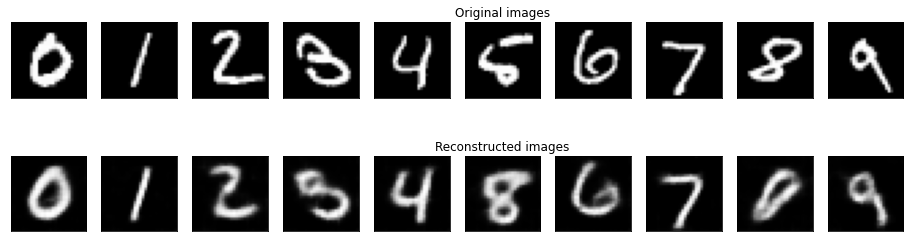

	 partial train loss (single batch): 0.027616
	 partial train loss (single batch): 0.026129
	 partial train loss (single batch): 0.028068
	 partial train loss (single batch): 0.026495
	 partial train loss (single batch): 0.026573
	 partial train loss (single batch): 0.025461
	 partial train loss (single batch): 0.027544
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.024246
	 partial train loss (single batch): 0.025173
	 partial train loss (single batch): 0.025785
	 partial train loss (single batch): 0.025174
	 partial train loss (single batch): 0.026136
	 partial train loss (single batch): 0.026546
	 partial train loss (single batch): 0.026435
	 partial train loss (single batch): 0.026021
	 partial train loss (single batch): 0.025433
	 partial train loss (single batch): 0.025753
	 partial train loss (single batch): 0.026247
	 partial train loss (single batch): 0.027204
	 partial train loss (single batch): 0.027237
	 partial train loss (single batch

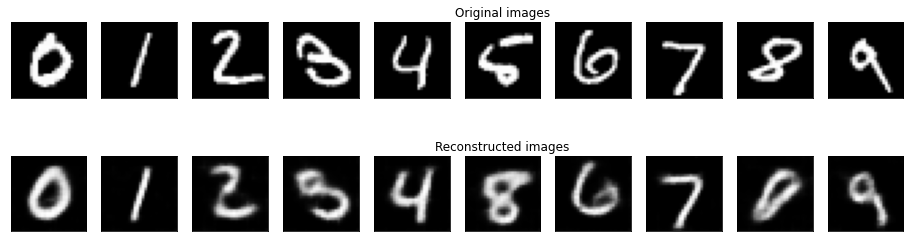

	 partial train loss (single batch): 0.027559
	 partial train loss (single batch): 0.026148
	 partial train loss (single batch): 0.028028
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.026500
	 partial train loss (single batch): 0.025336
	 partial train loss (single batch): 0.027452
	 partial train loss (single batch): 0.027323
	 partial train loss (single batch): 0.024142
	 partial train loss (single batch): 0.025094
	 partial train loss (single batch): 0.025718
	 partial train loss (single batch): 0.025090
	 partial train loss (single batch): 0.026126
	 partial train loss (single batch): 0.026390
	 partial train loss (single batch): 0.026378
	 partial train loss (single batch): 0.026039
	 partial train loss (single batch): 0.025370
	 partial train loss (single batch): 0.025743
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.027101
	 partial train loss (single batch): 0.027177
	 partial train loss (single batch

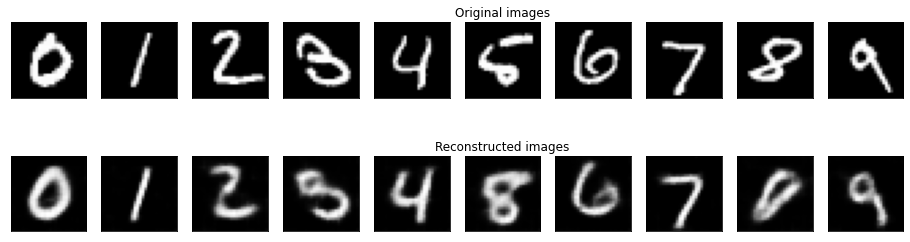

	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.025948
	 partial train loss (single batch): 0.027911
	 partial train loss (single batch): 0.026377
	 partial train loss (single batch): 0.026459
	 partial train loss (single batch): 0.025282
	 partial train loss (single batch): 0.027384
	 partial train loss (single batch): 0.027159
	 partial train loss (single batch): 0.024107
	 partial train loss (single batch): 0.025075
	 partial train loss (single batch): 0.025591
	 partial train loss (single batch): 0.025095
	 partial train loss (single batch): 0.026119
	 partial train loss (single batch): 0.026281
	 partial train loss (single batch): 0.026322
	 partial train loss (single batch): 0.026088
	 partial train loss (single batch): 0.025298
	 partial train loss (single batch): 0.025676
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.027077
	 partial train loss (single batch): 0.027194
	 partial train loss (single batch

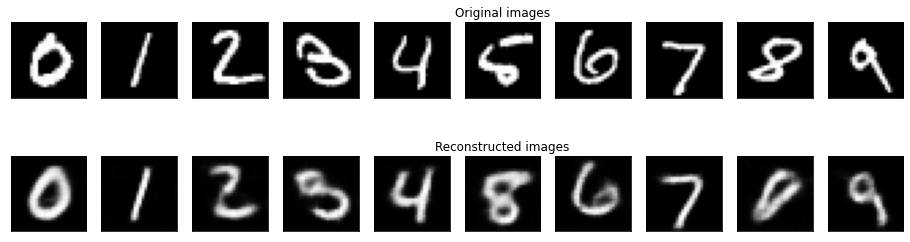

	 partial train loss (single batch): 0.027482
	 partial train loss (single batch): 0.025902
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.026291
	 partial train loss (single batch): 0.026356
	 partial train loss (single batch): 0.025189
	 partial train loss (single batch): 0.027344
	 partial train loss (single batch): 0.027096
	 partial train loss (single batch): 0.024057
	 partial train loss (single batch): 0.025073
	 partial train loss (single batch): 0.025507
	 partial train loss (single batch): 0.025005
	 partial train loss (single batch): 0.026126
	 partial train loss (single batch): 0.026219
	 partial train loss (single batch): 0.026275
	 partial train loss (single batch): 0.025943
	 partial train loss (single batch): 0.025318
	 partial train loss (single batch): 0.025588
	 partial train loss (single batch): 0.026137
	 partial train loss (single batch): 0.026950
	 partial train loss (single batch): 0.027152
	 partial train loss (single batch

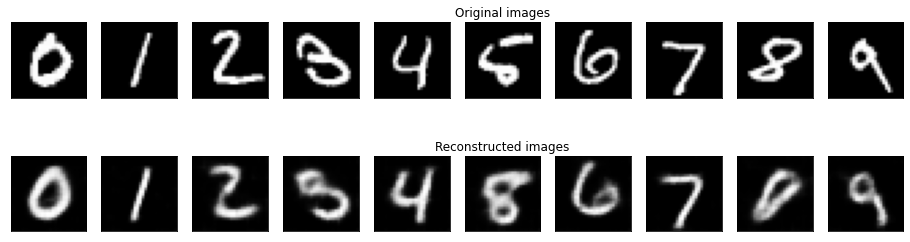

	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.025842
	 partial train loss (single batch): 0.027775
	 partial train loss (single batch): 0.026336
	 partial train loss (single batch): 0.026368
	 partial train loss (single batch): 0.025226
	 partial train loss (single batch): 0.027337
	 partial train loss (single batch): 0.027010
	 partial train loss (single batch): 0.024018
	 partial train loss (single batch): 0.025075
	 partial train loss (single batch): 0.025502
	 partial train loss (single batch): 0.024943
	 partial train loss (single batch): 0.026078
	 partial train loss (single batch): 0.026173
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.025285
	 partial train loss (single batch): 0.025469
	 partial train loss (single batch): 0.026075
	 partial train loss (single batch): 0.026951
	 partial train loss (single batch): 0.027046
	 partial train loss (single batch

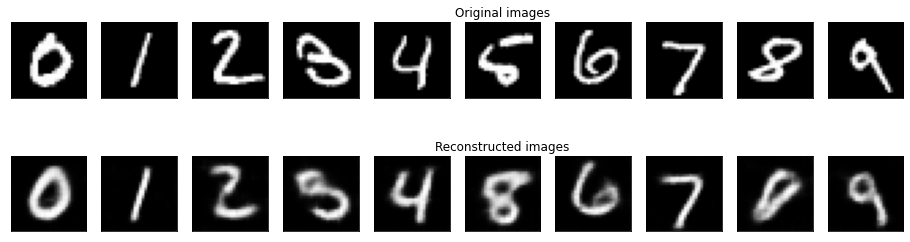

	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.025726
	 partial train loss (single batch): 0.027660
	 partial train loss (single batch): 0.026279
	 partial train loss (single batch): 0.026190
	 partial train loss (single batch): 0.025144
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.026864
	 partial train loss (single batch): 0.023969
	 partial train loss (single batch): 0.025011
	 partial train loss (single batch): 0.025373
	 partial train loss (single batch): 0.024835
	 partial train loss (single batch): 0.026058
	 partial train loss (single batch): 0.026064
	 partial train loss (single batch): 0.026116
	 partial train loss (single batch): 0.025879
	 partial train loss (single batch): 0.025150
	 partial train loss (single batch): 0.025459
	 partial train loss (single batch): 0.026050
	 partial train loss (single batch): 0.026871
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch

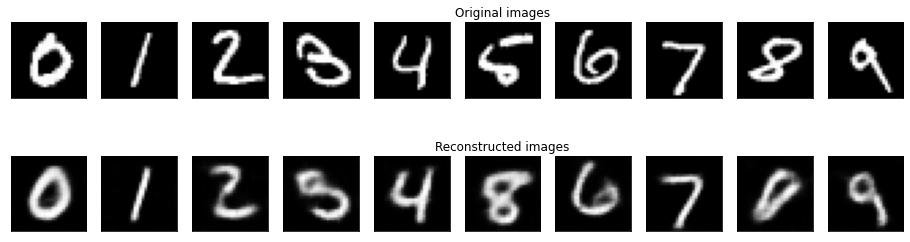

	 partial train loss (single batch): 0.027356
	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.027668
	 partial train loss (single batch): 0.026159
	 partial train loss (single batch): 0.026188
	 partial train loss (single batch): 0.025013
	 partial train loss (single batch): 0.027140
	 partial train loss (single batch): 0.026850
	 partial train loss (single batch): 0.023887
	 partial train loss (single batch): 0.024876
	 partial train loss (single batch): 0.025301
	 partial train loss (single batch): 0.024730
	 partial train loss (single batch): 0.025946
	 partial train loss (single batch): 0.026077
	 partial train loss (single batch): 0.026029
	 partial train loss (single batch): 0.025808
	 partial train loss (single batch): 0.025050
	 partial train loss (single batch): 0.025397
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.026799
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch

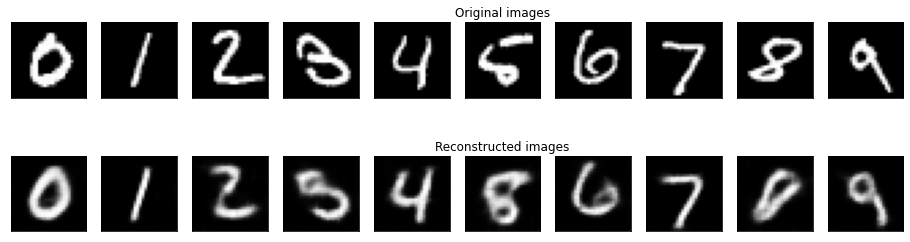

	 partial train loss (single batch): 0.027313
	 partial train loss (single batch): 0.025716
	 partial train loss (single batch): 0.027527
	 partial train loss (single batch): 0.026143
	 partial train loss (single batch): 0.026101
	 partial train loss (single batch): 0.025013
	 partial train loss (single batch): 0.027043
	 partial train loss (single batch): 0.026779
	 partial train loss (single batch): 0.023871
	 partial train loss (single batch): 0.024856
	 partial train loss (single batch): 0.025290
	 partial train loss (single batch): 0.024724
	 partial train loss (single batch): 0.025963
	 partial train loss (single batch): 0.025938
	 partial train loss (single batch): 0.025983
	 partial train loss (single batch): 0.025819
	 partial train loss (single batch): 0.025000
	 partial train loss (single batch): 0.025344
	 partial train loss (single batch): 0.025955
	 partial train loss (single batch): 0.026695
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch

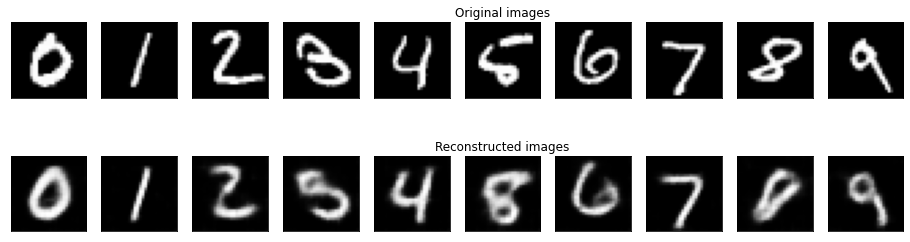

	 partial train loss (single batch): 0.027285
	 partial train loss (single batch): 0.025583
	 partial train loss (single batch): 0.027511
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.026072
	 partial train loss (single batch): 0.024980
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.026689
	 partial train loss (single batch): 0.023856
	 partial train loss (single batch): 0.024849
	 partial train loss (single batch): 0.025189
	 partial train loss (single batch): 0.024664
	 partial train loss (single batch): 0.025931
	 partial train loss (single batch): 0.025890
	 partial train loss (single batch): 0.025855
	 partial train loss (single batch): 0.025802
	 partial train loss (single batch): 0.024884
	 partial train loss (single batch): 0.025301
	 partial train loss (single batch): 0.025942
	 partial train loss (single batch): 0.026588
	 partial train loss (single batch): 0.026793
	 partial train loss (single batch

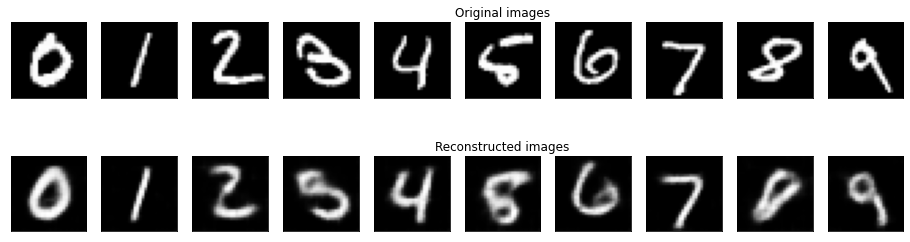

	 partial train loss (single batch): 0.027150
	 partial train loss (single batch): 0.025575
	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.026055
	 partial train loss (single batch): 0.026009
	 partial train loss (single batch): 0.024916
	 partial train loss (single batch): 0.026910
	 partial train loss (single batch): 0.026636
	 partial train loss (single batch): 0.023789
	 partial train loss (single batch): 0.024794
	 partial train loss (single batch): 0.025109
	 partial train loss (single batch): 0.024603
	 partial train loss (single batch): 0.025873
	 partial train loss (single batch): 0.025842
	 partial train loss (single batch): 0.025873
	 partial train loss (single batch): 0.025782
	 partial train loss (single batch): 0.024857
	 partial train loss (single batch): 0.025275
	 partial train loss (single batch): 0.025887
	 partial train loss (single batch): 0.026528
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch

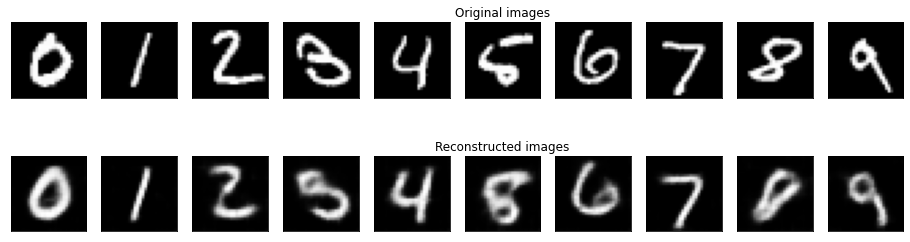

	 partial train loss (single batch): 0.027097
	 partial train loss (single batch): 0.025525
	 partial train loss (single batch): 0.027423
	 partial train loss (single batch): 0.025950
	 partial train loss (single batch): 0.025956
	 partial train loss (single batch): 0.024849
	 partial train loss (single batch): 0.026827
	 partial train loss (single batch): 0.026608
	 partial train loss (single batch): 0.023679
	 partial train loss (single batch): 0.024723
	 partial train loss (single batch): 0.025116
	 partial train loss (single batch): 0.024423
	 partial train loss (single batch): 0.025781
	 partial train loss (single batch): 0.025726
	 partial train loss (single batch): 0.025763
	 partial train loss (single batch): 0.025642
	 partial train loss (single batch): 0.024833
	 partial train loss (single batch): 0.025202
	 partial train loss (single batch): 0.025815
	 partial train loss (single batch): 0.026455
	 partial train loss (single batch): 0.026643
	 partial train loss (single batch

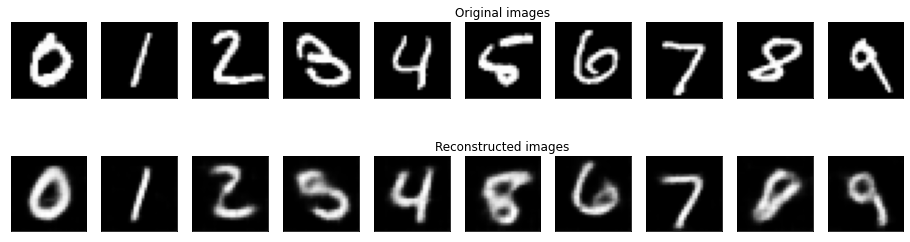

	 partial train loss (single batch): 0.027007
	 partial train loss (single batch): 0.025469
	 partial train loss (single batch): 0.027384
	 partial train loss (single batch): 0.025874
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch): 0.024763
	 partial train loss (single batch): 0.026860
	 partial train loss (single batch): 0.026576
	 partial train loss (single batch): 0.023645
	 partial train loss (single batch): 0.024724
	 partial train loss (single batch): 0.025015
	 partial train loss (single batch): 0.024489
	 partial train loss (single batch): 0.025743
	 partial train loss (single batch): 0.025701
	 partial train loss (single batch): 0.025818
	 partial train loss (single batch): 0.025602
	 partial train loss (single batch): 0.024812
	 partial train loss (single batch): 0.025188
	 partial train loss (single batch): 0.025815
	 partial train loss (single batch): 0.026363
	 partial train loss (single batch): 0.026647
	 partial train loss (single batch

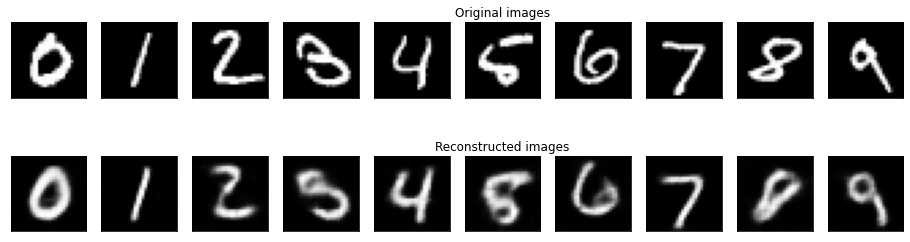

	 partial train loss (single batch): 0.026985
	 partial train loss (single batch): 0.025345
	 partial train loss (single batch): 0.027415
	 partial train loss (single batch): 0.025848
	 partial train loss (single batch): 0.025940
	 partial train loss (single batch): 0.024771
	 partial train loss (single batch): 0.026807
	 partial train loss (single batch): 0.026566
	 partial train loss (single batch): 0.023557
	 partial train loss (single batch): 0.024657
	 partial train loss (single batch): 0.025001
	 partial train loss (single batch): 0.024452
	 partial train loss (single batch): 0.025715
	 partial train loss (single batch): 0.025595
	 partial train loss (single batch): 0.025762
	 partial train loss (single batch): 0.025612
	 partial train loss (single batch): 0.024775
	 partial train loss (single batch): 0.025166
	 partial train loss (single batch): 0.025763
	 partial train loss (single batch): 0.026291
	 partial train loss (single batch): 0.026585
	 partial train loss (single batch

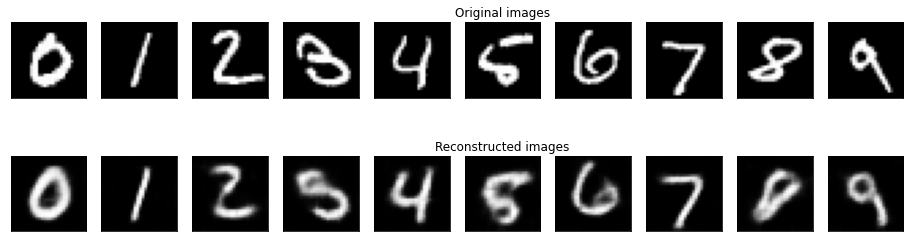

	 partial train loss (single batch): 0.026884
	 partial train loss (single batch): 0.025337
	 partial train loss (single batch): 0.027340
	 partial train loss (single batch): 0.025854
	 partial train loss (single batch): 0.025867
	 partial train loss (single batch): 0.024781
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.023559
	 partial train loss (single batch): 0.024682
	 partial train loss (single batch): 0.025116
	 partial train loss (single batch): 0.024488
	 partial train loss (single batch): 0.025754
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.025724
	 partial train loss (single batch): 0.025592
	 partial train loss (single batch): 0.024687
	 partial train loss (single batch): 0.025148
	 partial train loss (single batch): 0.025816
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.026624
	 partial train loss (single batch

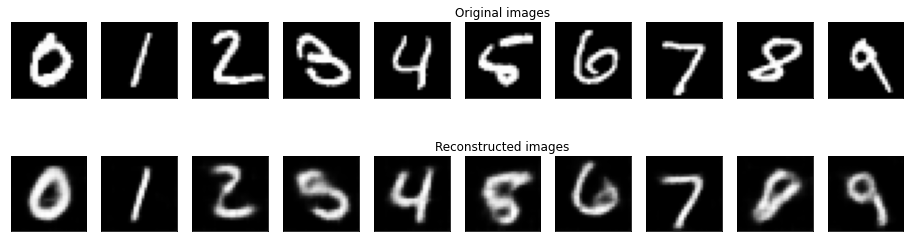

	 partial train loss (single batch): 0.026961
	 partial train loss (single batch): 0.025282
	 partial train loss (single batch): 0.027357
	 partial train loss (single batch): 0.025827
	 partial train loss (single batch): 0.025799
	 partial train loss (single batch): 0.024796
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.026489
	 partial train loss (single batch): 0.023582
	 partial train loss (single batch): 0.024618
	 partial train loss (single batch): 0.025012
	 partial train loss (single batch): 0.024391
	 partial train loss (single batch): 0.025685
	 partial train loss (single batch): 0.025608
	 partial train loss (single batch): 0.025653
	 partial train loss (single batch): 0.025571
	 partial train loss (single batch): 0.024628
	 partial train loss (single batch): 0.025055
	 partial train loss (single batch): 0.025717
	 partial train loss (single batch): 0.026180
	 partial train loss (single batch): 0.026513
	 partial train loss (single batch

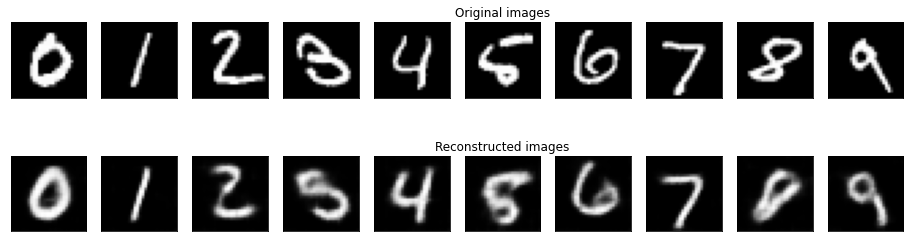

	 partial train loss (single batch): 0.026987
	 partial train loss (single batch): 0.025325
	 partial train loss (single batch): 0.027330
	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.025763
	 partial train loss (single batch): 0.024782
	 partial train loss (single batch): 0.026615
	 partial train loss (single batch): 0.026437
	 partial train loss (single batch): 0.023521
	 partial train loss (single batch): 0.024620
	 partial train loss (single batch): 0.024990
	 partial train loss (single batch): 0.024440
	 partial train loss (single batch): 0.025664
	 partial train loss (single batch): 0.025527
	 partial train loss (single batch): 0.025586
	 partial train loss (single batch): 0.025546
	 partial train loss (single batch): 0.024616
	 partial train loss (single batch): 0.024987
	 partial train loss (single batch): 0.025747
	 partial train loss (single batch): 0.026194
	 partial train loss (single batch): 0.026501
	 partial train loss (single batch

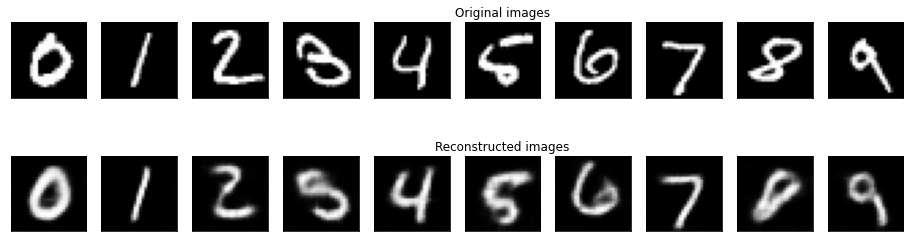

	 partial train loss (single batch): 0.026929
	 partial train loss (single batch): 0.025181
	 partial train loss (single batch): 0.027399
	 partial train loss (single batch): 0.025744
	 partial train loss (single batch): 0.025714
	 partial train loss (single batch): 0.024710
	 partial train loss (single batch): 0.026563
	 partial train loss (single batch): 0.026328
	 partial train loss (single batch): 0.023534
	 partial train loss (single batch): 0.024661
	 partial train loss (single batch): 0.024934
	 partial train loss (single batch): 0.024442
	 partial train loss (single batch): 0.025765
	 partial train loss (single batch): 0.025466
	 partial train loss (single batch): 0.025506
	 partial train loss (single batch): 0.025556
	 partial train loss (single batch): 0.024640
	 partial train loss (single batch): 0.025032
	 partial train loss (single batch): 0.025744
	 partial train loss (single batch): 0.026171
	 partial train loss (single batch): 0.026560
	 partial train loss (single batch

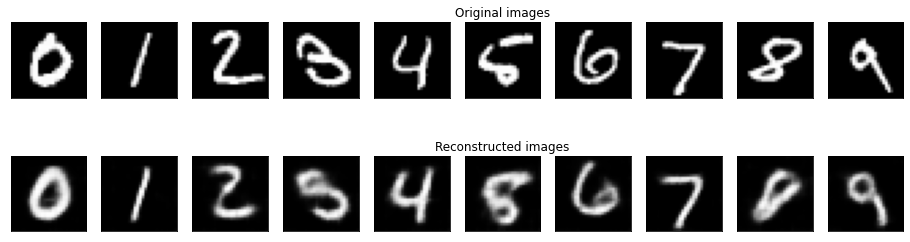

	 partial train loss (single batch): 0.026883
	 partial train loss (single batch): 0.025183
	 partial train loss (single batch): 0.027378
	 partial train loss (single batch): 0.025739
	 partial train loss (single batch): 0.025720
	 partial train loss (single batch): 0.024760
	 partial train loss (single batch): 0.026513
	 partial train loss (single batch): 0.026368
	 partial train loss (single batch): 0.023457
	 partial train loss (single batch): 0.024582
	 partial train loss (single batch): 0.024909
	 partial train loss (single batch): 0.024410
	 partial train loss (single batch): 0.025719
	 partial train loss (single batch): 0.025510
	 partial train loss (single batch): 0.025505
	 partial train loss (single batch): 0.025585
	 partial train loss (single batch): 0.024625
	 partial train loss (single batch): 0.024970
	 partial train loss (single batch): 0.025666
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.026502
	 partial train loss (single batch

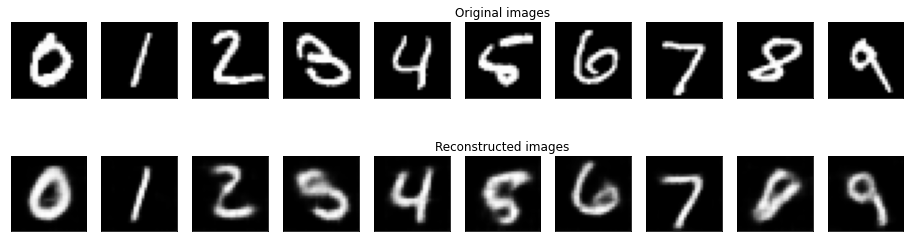

	 partial train loss (single batch): 0.026767
	 partial train loss (single batch): 0.025144
	 partial train loss (single batch): 0.027355
	 partial train loss (single batch): 0.025619
	 partial train loss (single batch): 0.025617
	 partial train loss (single batch): 0.024668
	 partial train loss (single batch): 0.026431
	 partial train loss (single batch): 0.026288
	 partial train loss (single batch): 0.023396
	 partial train loss (single batch): 0.024486
	 partial train loss (single batch): 0.024787
	 partial train loss (single batch): 0.024237
	 partial train loss (single batch): 0.025594
	 partial train loss (single batch): 0.025392
	 partial train loss (single batch): 0.025478
	 partial train loss (single batch): 0.025488
	 partial train loss (single batch): 0.024616
	 partial train loss (single batch): 0.024937
	 partial train loss (single batch): 0.025554
	 partial train loss (single batch): 0.026056
	 partial train loss (single batch): 0.026568
	 partial train loss (single batch

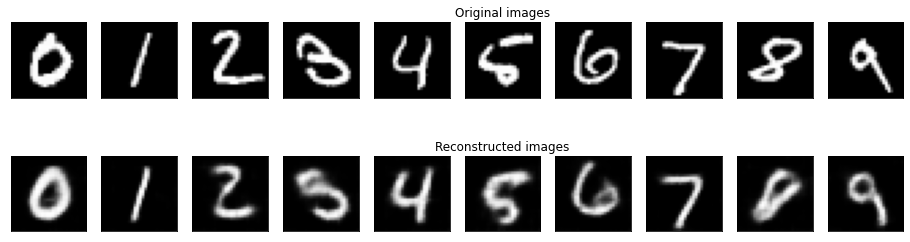

	 partial train loss (single batch): 0.026879
	 partial train loss (single batch): 0.025095
	 partial train loss (single batch): 0.027274
	 partial train loss (single batch): 0.025623
	 partial train loss (single batch): 0.025647
	 partial train loss (single batch): 0.024660
	 partial train loss (single batch): 0.026454
	 partial train loss (single batch): 0.026268
	 partial train loss (single batch): 0.023428
	 partial train loss (single batch): 0.024525
	 partial train loss (single batch): 0.024806
	 partial train loss (single batch): 0.024270
	 partial train loss (single batch): 0.025569
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch): 0.025420
	 partial train loss (single batch): 0.025459
	 partial train loss (single batch): 0.024570
	 partial train loss (single batch): 0.024892
	 partial train loss (single batch): 0.025639
	 partial train loss (single batch): 0.026066
	 partial train loss (single batch): 0.026471
	 partial train loss (single batch

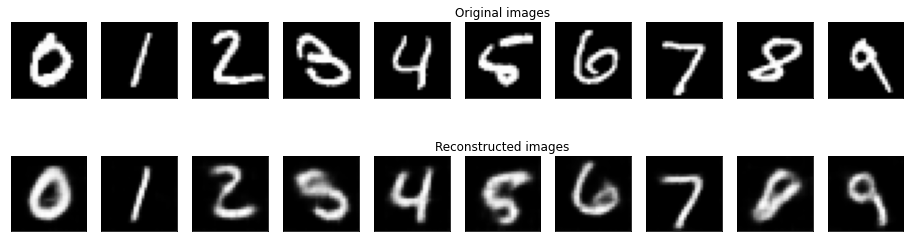

	 partial train loss (single batch): 0.026690
	 partial train loss (single batch): 0.025076
	 partial train loss (single batch): 0.027235
	 partial train loss (single batch): 0.025531
	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.024614
	 partial train loss (single batch): 0.026410
	 partial train loss (single batch): 0.026268
	 partial train loss (single batch): 0.023393
	 partial train loss (single batch): 0.024366
	 partial train loss (single batch): 0.024750
	 partial train loss (single batch): 0.024186
	 partial train loss (single batch): 0.025601
	 partial train loss (single batch): 0.025410
	 partial train loss (single batch): 0.025338
	 partial train loss (single batch): 0.025429
	 partial train loss (single batch): 0.024521
	 partial train loss (single batch): 0.024841
	 partial train loss (single batch): 0.025683
	 partial train loss (single batch): 0.026017
	 partial train loss (single batch): 0.026410
	 partial train loss (single batch

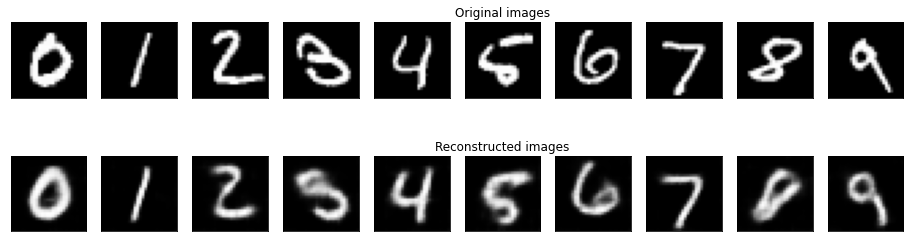

	 partial train loss (single batch): 0.026691
	 partial train loss (single batch): 0.025043
	 partial train loss (single batch): 0.027221
	 partial train loss (single batch): 0.025562
	 partial train loss (single batch): 0.025586
	 partial train loss (single batch): 0.024536
	 partial train loss (single batch): 0.026336
	 partial train loss (single batch): 0.026226
	 partial train loss (single batch): 0.023360
	 partial train loss (single batch): 0.024360
	 partial train loss (single batch): 0.024721
	 partial train loss (single batch): 0.024168
	 partial train loss (single batch): 0.025577
	 partial train loss (single batch): 0.025333
	 partial train loss (single batch): 0.025333
	 partial train loss (single batch): 0.025374
	 partial train loss (single batch): 0.024469
	 partial train loss (single batch): 0.024813
	 partial train loss (single batch): 0.025525
	 partial train loss (single batch): 0.025924
	 partial train loss (single batch): 0.026474
	 partial train loss (single batch

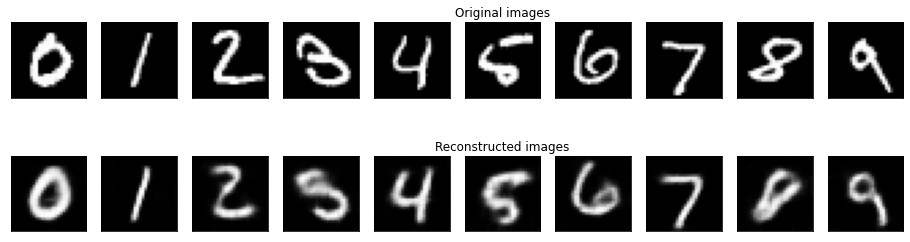

	 partial train loss (single batch): 0.026637
	 partial train loss (single batch): 0.025058
	 partial train loss (single batch): 0.027146
	 partial train loss (single batch): 0.025471
	 partial train loss (single batch): 0.025505
	 partial train loss (single batch): 0.024592
	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.026227
	 partial train loss (single batch): 0.023327
	 partial train loss (single batch): 0.024353
	 partial train loss (single batch): 0.024643
	 partial train loss (single batch): 0.024192
	 partial train loss (single batch): 0.025477
	 partial train loss (single batch): 0.025262
	 partial train loss (single batch): 0.025313
	 partial train loss (single batch): 0.025254
	 partial train loss (single batch): 0.024453
	 partial train loss (single batch): 0.024778
	 partial train loss (single batch): 0.025487
	 partial train loss (single batch): 0.025931
	 partial train loss (single batch): 0.026378
	 partial train loss (single batch

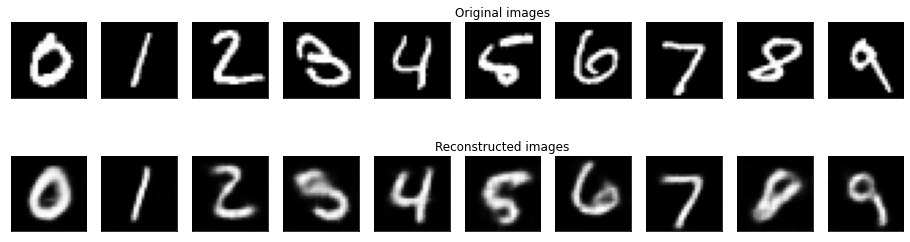

	 partial train loss (single batch): 0.026724
	 partial train loss (single batch): 0.025021
	 partial train loss (single batch): 0.027120
	 partial train loss (single batch): 0.025467
	 partial train loss (single batch): 0.025543
	 partial train loss (single batch): 0.024540
	 partial train loss (single batch): 0.026298
	 partial train loss (single batch): 0.026167
	 partial train loss (single batch): 0.023383
	 partial train loss (single batch): 0.024353
	 partial train loss (single batch): 0.024680
	 partial train loss (single batch): 0.024095
	 partial train loss (single batch): 0.025455
	 partial train loss (single batch): 0.025247
	 partial train loss (single batch): 0.025242
	 partial train loss (single batch): 0.025308
	 partial train loss (single batch): 0.024511
	 partial train loss (single batch): 0.024832
	 partial train loss (single batch): 0.025464
	 partial train loss (single batch): 0.025939
	 partial train loss (single batch): 0.026371
	 partial train loss (single batch

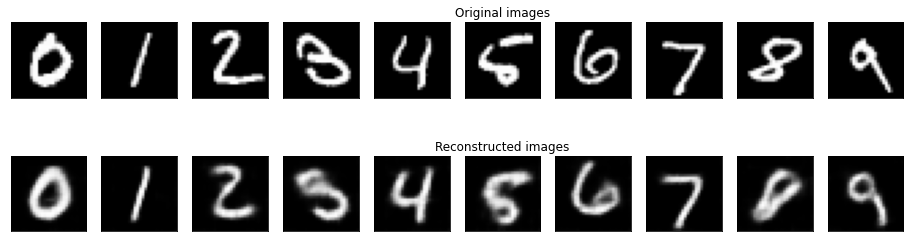

	 partial train loss (single batch): 0.026555
	 partial train loss (single batch): 0.025073
	 partial train loss (single batch): 0.027182
	 partial train loss (single batch): 0.025460
	 partial train loss (single batch): 0.025587
	 partial train loss (single batch): 0.024605
	 partial train loss (single batch): 0.026258
	 partial train loss (single batch): 0.026170
	 partial train loss (single batch): 0.023335
	 partial train loss (single batch): 0.024402
	 partial train loss (single batch): 0.024604
	 partial train loss (single batch): 0.024144
	 partial train loss (single batch): 0.025562
	 partial train loss (single batch): 0.025235
	 partial train loss (single batch): 0.025285
	 partial train loss (single batch): 0.025182
	 partial train loss (single batch): 0.024404
	 partial train loss (single batch): 0.024792
	 partial train loss (single batch): 0.025465
	 partial train loss (single batch): 0.025924
	 partial train loss (single batch): 0.026426
	 partial train loss (single batch

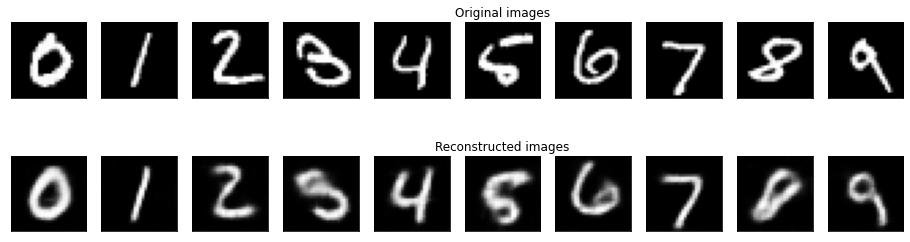

	 partial train loss (single batch): 0.026683
	 partial train loss (single batch): 0.025082
	 partial train loss (single batch): 0.027102
	 partial train loss (single batch): 0.025509
	 partial train loss (single batch): 0.025570
	 partial train loss (single batch): 0.024567
	 partial train loss (single batch): 0.026229
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.023443
	 partial train loss (single batch): 0.024281
	 partial train loss (single batch): 0.024533
	 partial train loss (single batch): 0.024184
	 partial train loss (single batch): 0.025490
	 partial train loss (single batch): 0.025192
	 partial train loss (single batch): 0.025194
	 partial train loss (single batch): 0.025122
	 partial train loss (single batch): 0.024497
	 partial train loss (single batch): 0.024698
	 partial train loss (single batch): 0.025466
	 partial train loss (single batch): 0.025916
	 partial train loss (single batch): 0.026456
	 partial train loss (single batch

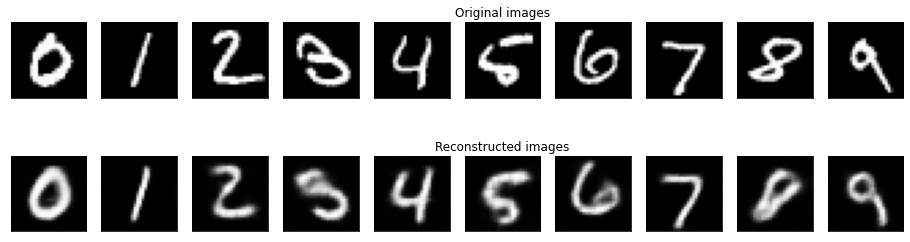

	 partial train loss (single batch): 0.026528
	 partial train loss (single batch): 0.025123
	 partial train loss (single batch): 0.027077
	 partial train loss (single batch): 0.025463
	 partial train loss (single batch): 0.025601
	 partial train loss (single batch): 0.024620
	 partial train loss (single batch): 0.026213
	 partial train loss (single batch): 0.026160
	 partial train loss (single batch): 0.023406
	 partial train loss (single batch): 0.024352
	 partial train loss (single batch): 0.024529
	 partial train loss (single batch): 0.024092
	 partial train loss (single batch): 0.025522
	 partial train loss (single batch): 0.025244
	 partial train loss (single batch): 0.025152
	 partial train loss (single batch): 0.025133
	 partial train loss (single batch): 0.024384
	 partial train loss (single batch): 0.024690
	 partial train loss (single batch): 0.025354
	 partial train loss (single batch): 0.025812
	 partial train loss (single batch): 0.026406
	 partial train loss (single batch

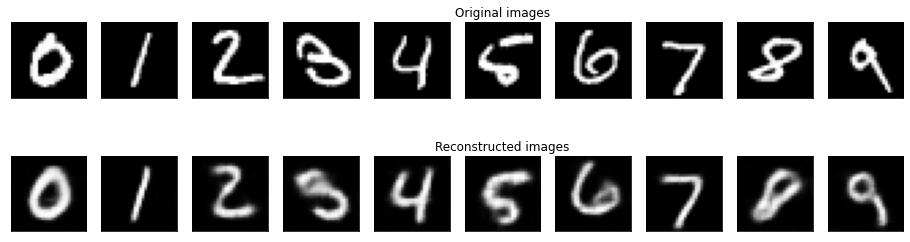

	 partial train loss (single batch): 0.026522
	 partial train loss (single batch): 0.025012
	 partial train loss (single batch): 0.027174
	 partial train loss (single batch): 0.025482
	 partial train loss (single batch): 0.025542
	 partial train loss (single batch): 0.024598
	 partial train loss (single batch): 0.026217
	 partial train loss (single batch): 0.026038
	 partial train loss (single batch): 0.023399
	 partial train loss (single batch): 0.024244
	 partial train loss (single batch): 0.024448
	 partial train loss (single batch): 0.024063
	 partial train loss (single batch): 0.025490
	 partial train loss (single batch): 0.025154
	 partial train loss (single batch): 0.025178
	 partial train loss (single batch): 0.025046
	 partial train loss (single batch): 0.024524
	 partial train loss (single batch): 0.024687
	 partial train loss (single batch): 0.025457
	 partial train loss (single batch): 0.025829
	 partial train loss (single batch): 0.026509
	 partial train loss (single batch

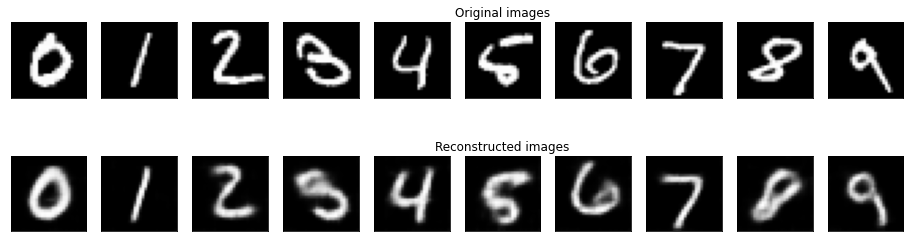

	 partial train loss (single batch): 0.026406
	 partial train loss (single batch): 0.024920
	 partial train loss (single batch): 0.027136
	 partial train loss (single batch): 0.025463
	 partial train loss (single batch): 0.025451
	 partial train loss (single batch): 0.024568
	 partial train loss (single batch): 0.026217
	 partial train loss (single batch): 0.026091
	 partial train loss (single batch): 0.023262
	 partial train loss (single batch): 0.024308
	 partial train loss (single batch): 0.024431
	 partial train loss (single batch): 0.023918
	 partial train loss (single batch): 0.025400
	 partial train loss (single batch): 0.025223
	 partial train loss (single batch): 0.025157
	 partial train loss (single batch): 0.024970
	 partial train loss (single batch): 0.024428
	 partial train loss (single batch): 0.024681
	 partial train loss (single batch): 0.025370
	 partial train loss (single batch): 0.025765
	 partial train loss (single batch): 0.026504
	 partial train loss (single batch

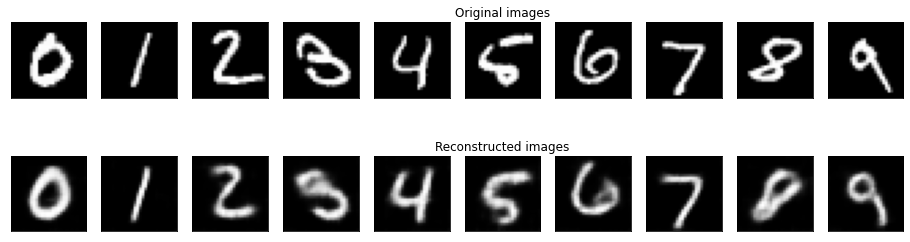

	 partial train loss (single batch): 0.026331
	 partial train loss (single batch): 0.024978
	 partial train loss (single batch): 0.027211
	 partial train loss (single batch): 0.025510
	 partial train loss (single batch): 0.025518
	 partial train loss (single batch): 0.024708
	 partial train loss (single batch): 0.026256
	 partial train loss (single batch): 0.026087
	 partial train loss (single batch): 0.023388
	 partial train loss (single batch): 0.024269
	 partial train loss (single batch): 0.024430
	 partial train loss (single batch): 0.023949
	 partial train loss (single batch): 0.025424
	 partial train loss (single batch): 0.025243
	 partial train loss (single batch): 0.025132
	 partial train loss (single batch): 0.024978
	 partial train loss (single batch): 0.024566
	 partial train loss (single batch): 0.024694
	 partial train loss (single batch): 0.025312
	 partial train loss (single batch): 0.025786
	 partial train loss (single batch): 0.026384
	 partial train loss (single batch

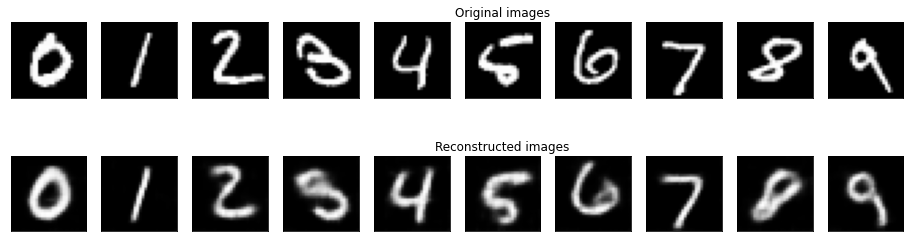

	 partial train loss (single batch): 0.026361
	 partial train loss (single batch): 0.024932
	 partial train loss (single batch): 0.027195
	 partial train loss (single batch): 0.025548
	 partial train loss (single batch): 0.025437
	 partial train loss (single batch): 0.024588
	 partial train loss (single batch): 0.026231
	 partial train loss (single batch): 0.026100
	 partial train loss (single batch): 0.023365
	 partial train loss (single batch): 0.024265
	 partial train loss (single batch): 0.024546
	 partial train loss (single batch): 0.023954
	 partial train loss (single batch): 0.025311
	 partial train loss (single batch): 0.025199
	 partial train loss (single batch): 0.025118
	 partial train loss (single batch): 0.024979
	 partial train loss (single batch): 0.024505
	 partial train loss (single batch): 0.024829
	 partial train loss (single batch): 0.025432
	 partial train loss (single batch): 0.025800
	 partial train loss (single batch): 0.026404
	 partial train loss (single batch

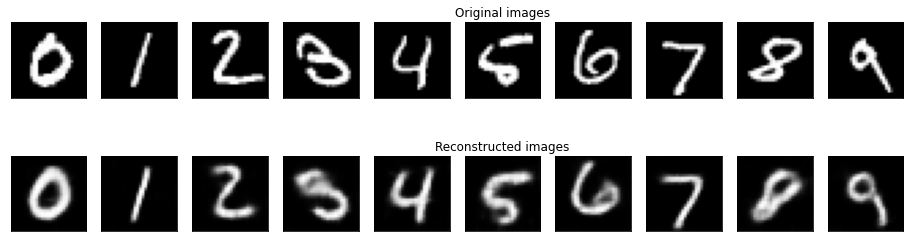

	 partial train loss (single batch): 0.026236
	 partial train loss (single batch): 0.024963
	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.025518
	 partial train loss (single batch): 0.025407
	 partial train loss (single batch): 0.024702
	 partial train loss (single batch): 0.026318
	 partial train loss (single batch): 0.026120
	 partial train loss (single batch): 0.023348
	 partial train loss (single batch): 0.024206
	 partial train loss (single batch): 0.024435
	 partial train loss (single batch): 0.023912
	 partial train loss (single batch): 0.025301
	 partial train loss (single batch): 0.025211
	 partial train loss (single batch): 0.025209
	 partial train loss (single batch): 0.024951
	 partial train loss (single batch): 0.024435
	 partial train loss (single batch): 0.024769
	 partial train loss (single batch): 0.025359
	 partial train loss (single batch): 0.025761
	 partial train loss (single batch): 0.026371
	 partial train loss (single batch

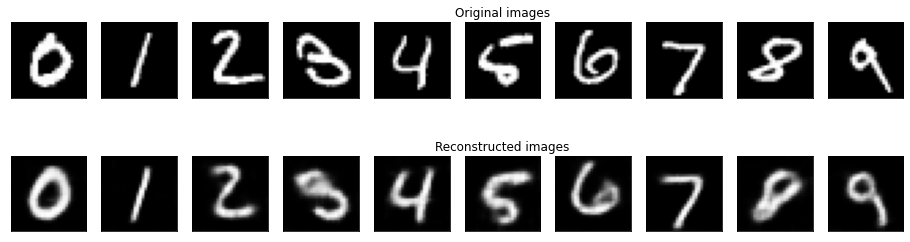

	 partial train loss (single batch): 0.026268
	 partial train loss (single batch): 0.024823
	 partial train loss (single batch): 0.027151
	 partial train loss (single batch): 0.025513
	 partial train loss (single batch): 0.025344
	 partial train loss (single batch): 0.024567
	 partial train loss (single batch): 0.026358
	 partial train loss (single batch): 0.026076
	 partial train loss (single batch): 0.023317
	 partial train loss (single batch): 0.024166
	 partial train loss (single batch): 0.024449
	 partial train loss (single batch): 0.023866
	 partial train loss (single batch): 0.025213
	 partial train loss (single batch): 0.025206
	 partial train loss (single batch): 0.025146
	 partial train loss (single batch): 0.024931
	 partial train loss (single batch): 0.024503
	 partial train loss (single batch): 0.024797
	 partial train loss (single batch): 0.025342
	 partial train loss (single batch): 0.025760
	 partial train loss (single batch): 0.026327
	 partial train loss (single batch

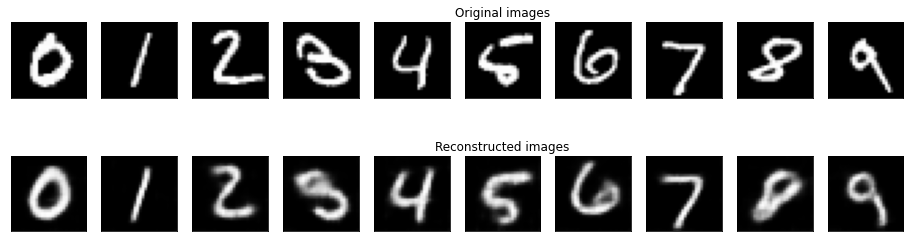

	 partial train loss (single batch): 0.026278
	 partial train loss (single batch): 0.024772
	 partial train loss (single batch): 0.027134
	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.025286
	 partial train loss (single batch): 0.024525
	 partial train loss (single batch): 0.026203
	 partial train loss (single batch): 0.025987
	 partial train loss (single batch): 0.023173
	 partial train loss (single batch): 0.024100
	 partial train loss (single batch): 0.024368
	 partial train loss (single batch): 0.023876
	 partial train loss (single batch): 0.025129
	 partial train loss (single batch): 0.025124
	 partial train loss (single batch): 0.025106
	 partial train loss (single batch): 0.024871
	 partial train loss (single batch): 0.024383
	 partial train loss (single batch): 0.024844
	 partial train loss (single batch): 0.025361
	 partial train loss (single batch): 0.025733
	 partial train loss (single batch): 0.026395
	 partial train loss (single batch

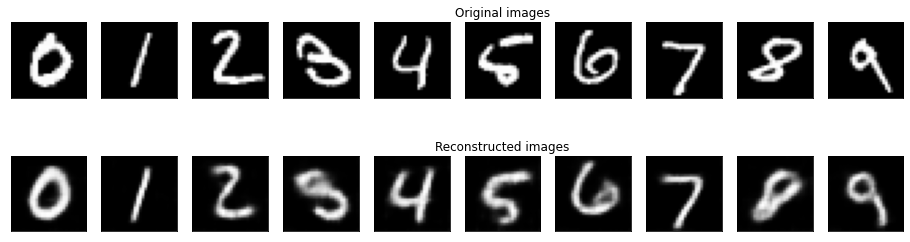

In [10]:
num_epochs = 60
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [11]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02612660452723503

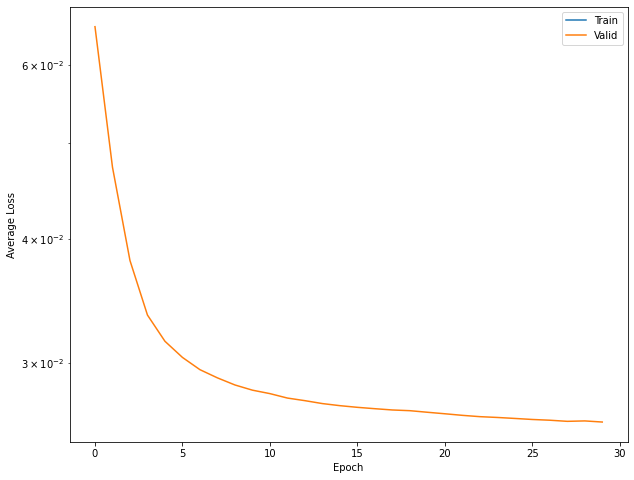

In [12]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')

tensor([-0.1609,  0.2441,  0.1900,  0.0251])
tensor([0.6018, 0.7743, 0.5834, 0.5737])


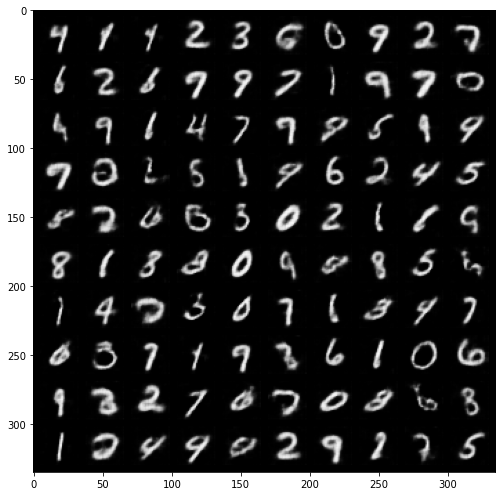

In [13]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()